# Introduction
The bike has 20 gears with a linear relationship of speed to power independently of the selected gear. So the observed speed of the app can predict the power in any gear. The advantage of this method is that gear changes does not have the need for switching to a different model.

Presumption: the trainer resistance never changes.


# Problem
Question: Find a model that predicts the Speed-by-app -> Power-by-tacx and how can we correlate each possible observing speed value with a correct power value?

# Solutione
Use two data sets of the same gear for tacx and app data and correlate an observation of the app with a observation in the tacx data set  by cadence. Cause cadence could a decimal value use a nearest neighbor regressor for each cadence/speed value in the app data.

1. Train Radius nearest neighbor regressor with distance of 0.5 so use the cadence value minus 0.5 and plus 0.5 rpm using tacx X [Cadence] -> y [power]
2. Predict power by using app's data X [cadence].
3. Create a linear model with app's data speed to predicted power values

Shape X_train/X_test: (424, 1)/(23, 1)
Error R²: 0.99
MSE error (mean squared error / variance): 3.69
sqrt(MSE) (standard deviation): 1.92
Max error: 7.964791140575201
Cross validation: [0.99200456 0.99238709 0.9839615  0.79185034 0.97599521]


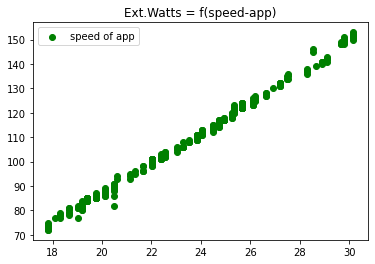

In [6]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from src.validation.regression import validate_lin_reg

from src.tcx import Tcx, COLUMN_NAME_SPEED, COLUMN_NAME_WATTS, COLUMN_NAME_CADENCE, COLUMN_NAME_ACCELERATION, COLUMN_NAME_CADENCE_RATE
from src.test_data import TrainDataSet
from src.visu import plot2d, show

COLUMN_NAME_SPEED_APP = "speed-app"

tcx_app_gear7: Tcx = Tcx.read_tcx(file_path='test/tcx/cadence_1612535177298-gear7.tcx')
tcx_tacx_gear7: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')
tcx_tacx_gear20: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')

# generate test data
dts_app_gear7: TrainDataSet = TrainDataSet(tcx_app_gear7)
dts_tacx_gear7: TrainDataSet = TrainDataSet(tcx_tacx_gear7)
df_tacx_gear7 = dts_tacx_gear7.get_dataframe()
df_app_gear7 = dts_app_gear7.get_dataframe()

def correlate_speed_by_cadence(df: pd.DataFrame, cadence: pd.Series) -> pd.Series:
    def create_regressor():
        return KNeighborsRegressor(n_neighbors=3, weights='uniform')

    def train_regressor(X, y):
        return create_regressor().fit(X, y)

    y = train_regressor(df[[COLUMN_NAME_CADENCE]], df[COLUMN_NAME_SPEED]).predict(cadence.to_frame())

    return pd.Series(y, name=COLUMN_NAME_SPEED_APP, index=cadence.index)

# predict
s_speed = correlate_speed_by_cadence(df_app_gear7, df_tacx_gear7[COLUMN_NAME_CADENCE])
df_tacx_gear7[s_speed.name] = s_speed
# count = pd.Series(y_predicted).where[lambda x: x == np.NaN].size()
# print(count)

# verification
X_train, X_test, y_train, y_test = train_test_split(df_tacx_gear7[[COLUMN_NAME_SPEED_APP]], df_tacx_gear7[COLUMN_NAME_WATTS], train_size=0.95)

validate_lin_reg(X_train, y_train, X_test, y_test, estimator=LinearRegression())
plot2d(df_tacx_gear7[COLUMN_NAME_SPEED_APP], df_tacx_gear7[COLUMN_NAME_WATTS], legend_label='speed of app', point_color='g')
show()


